# Building Permit Metrics of San Francisco

## Packages & Raw Data Import

In [1]:
import geopandas as gpd
import pandas as pd

import os 
os.chdir(r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics')

In [2]:
DATA_FOLDER = r'data'
META_FOLDER = DATA_FOLDER + r'\meta'
RAW_FOLDER = DATA_FOLDER + r'\raw'
CLEAN_FOLDER = DATA_FOLDER + r'\clean'

Import in San Francisco Neighborhoods and Quadrants

In [3]:
project_crs = 'EPSG:7132'
path = RAW_FOLDER + r'\georeference\sf_neighborhoods.geojson'
sfnhood = gpd.read_file(path).to_crs(project_crs)
project_crs = sfnhood.crs

path = RAW_FOLDER + r'\georeference\sf_quadrants.geojson'
sfquad = gpd.read_file(path).to_crs(project_crs)

path = CLEAN_FOLDER + r'\sf_2010censusblock.geojson'
sfblock = gpd.read_file(path).to_crs(project_crs)

### Import San Francisco Planning Permits 2016-2022
Pre-Cleaned Accela Permits from SF Open Data Portal ([pre-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-before-January-1-2013/)
 or [post-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-on-or-after-January-1-2013/))

Column Metadata to rename columns & determine which ones to keep

In [13]:
path = META_FOLDER + r'\sf_planning_permit_fields.xlsx'
sfp_meta = pd.read_excel(path)

new_col_names = {
    old.lower():new for old,new in sfp_meta[['Column Name','New Name']].values 
    if type(new) == str
}
keep_cols = sfp_meta.loc[sfp_meta['Keep']=='y', 'Column Name'].str.lower().to_list() + ['geometry']

Import in geojson of geolocated & cleaned permits

In [15]:
import pandas as pd
import geopandas as gpd

path = RAW_FOLDER + r'\sf_planning_permits_20220321.geojson'
sfp_full = gpd.read_file(path)

Prepare Dataset:
1. Filter by 'Project Profile' permits *(which are the 'main' permit)* & columns
2. Rename columns with metadata
3. Set integer & date type columns
4. Filter by permits with some form of proposed units
5. Remove Empty Geometry
6. Filter permits by:
    * A Start Date of Mid-2014
    * A Close Date of Mid-2015
7. Join to Neighborhoods

In [16]:
# 1. FILTER BY PERMIT TYPE
prj_filt = sfp_full['record_type']=='PRJ'
sfp = sfp_full[prj_filt][keep_cols].copy()

# 2. RENAME COLUMNS
sfp.columns = [
    new_col_names[c] if c in new_col_names.keys()
    else c
    for c in list(sfp)
]

# 3. SET DATA TYPES
## INTEGERS
unit_col = [c for c in list(sfp) if '#' in c]
sfp[unit_col] = sfp[unit_col].astype(float).astype(int)
## DATES
date_col = [c for c in list(sfp) if 'date' in c]
sfp[date_col] = sfp[date_col].apply(pd.to_datetime)

# 4. FILTER BY UNITS
all_filt = sfp['#units_prop']>0
mr_filt = sfp['#units_prop_mr']>0
sfp = sfp[all_filt|mr_filt]

# 5. REMOVE EMPTY GEOMETRY
sfp = sfp[~sfp['geometry'].is_empty] 
sfp_all = sfp.copy()

# 6. SET DATES 
## OPEN DATE OF 2014
date_open = '2014Q3'
open_filt = sfp['date_open']>date_open
## CLOSE DATE OF MID-2015
date_close = '2015Q3'
close_filt = sfp['date_close'].dt.to_period("Q")>=date_close
sfp = sfp[open_filt&close_filt]

# 7. JOIN TO NEIGHBORHOODS
sfp = sfp.sjoin(sfnhood).drop(columns='index_right')

### Building Permits

In [5]:
path = RAW_FOLDER + r'\sf_building_permits_20220411.csv'
sfb_full = pd.read_csv(path)

path = META_FOLDER + r'\sf_building_permit_fields.xlsx'
sfb_meta = pd.read_excel(path)
sfb_meta = sfb_meta.loc[sfb_meta['keep']=='y'].set_index('name')['new_name'].to_dict()

#for c in sfb_meta.keys(): 
#    if c not in list(sfb_full):
#        print(c)

sfb_full = sfb_full[sfb_meta.keys()].rename(columns=sfb_meta).sort_values('date_issued')
for c in [c for c in sfb_meta.values() if 'date' in c]:
    sfb_full[c] = pd.to_datetime(sfb_full[c])
sfb_full.head(-10)

C:\ProgramData\Miniconda3\envs\permit_metrics\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,pid,rid,date_start,desc,status,units_prop,use_prop,date_status,geometry,date_issued
177,9908229S,836112162081,1999-04-28,erect a three story fourteen unit residential ...,complete,14,apartments,2003-05-14,POINT (-122.41241836934992 37.756039544888395),2001-01-02
443,200002222441,805277386263,2000-02-22,erect 2 story single family dwelling,complete,1,1 family dwelling,2002-08-06,POINT (-122.46369767113859 37.74514388048755),2001-01-02
442,200002222434,805157146486,2000-02-22,erect a new two story single family dwelling,complete,1,1 family dwelling,2002-08-06,POINT (-122.4636154847457 37.74520807711159),2001-01-02
176,9908229S,836111162082,1999-04-28,erect a three story fourteen unit residential ...,complete,14,apartments,2003-05-14,POINT (-122.41253760625708 37.756031983169024),2001-01-02
3593,200003305890,80903197856,2000-03-30,"to erect 4 stories, 3 family dwelling",complete,3,apartments,2003-09-26,POINT (-122.48551931234834 37.78410694871072),2002-01-02
...,...,...,...,...,...,...,...,...,...,...
3199,201603091627,141542365198,2016-03-09,"""to erect 7 stories, 2 basement, 44 units resi...",complete,44,apartments,2021-06-02,POINT (-122.40871075447689 37.79179111500465),2017-12-29
2960,201501236483,1368686163487,2015-01-23,"to erect 4-story, no basement, type v-a, 20 un...",complete,20,apartments,2019-09-19,POINT (-122.4124491067438 37.755346399211234),2017-12-29
3197,201603091627,141572865197,2016-03-09,"""to erect 7 stories, 2 basement, 44 units resi...",complete,44,apartments,2021-06-02,POINT (-122.40891353684216 37.79178408985493),2017-12-29
764,200103164442,1039666449198,2001-03-16,erect a four story three unit residential bldg,complete,3,apartments,2008-05-22,POINT (-122.48350922685137 37.784197411573714),2005-12-30


In [123]:
sfbg = sfb['pid','rid', 'geometry']


['Permit Number',
 'Permit Type',
 'Permit Type Definition',
 'Permit Creation Date',
 'Block',
 'Lot',
 'Street Number',
 'Street Number Suffix',
 'Street Name',
 'Street Suffix',
 'Unit',
 'Unit Suffix',
 'Description',
 'Current Status',
 'Current Status Date',
 'Filed Date',
 'Issued Date',
 'Completed Date',
 'First Construction Document Date',
 'Structural Notification',
 'Number of Existing Stories',
 'Number of Proposed Stories',
 'Voluntary Soft-Story Retrofit',
 'Fire Only Permit',
 'Permit Expiration Date',
 'Estimated Cost',
 'Revised Cost',
 'Existing Use',
 'Existing Units',
 'Proposed Use',
 'Proposed Units',
 'Plansets',
 'TIDF Compliance',
 'Existing Construction Type',
 'Existing Construction Type Description',
 'Proposed Construction Type',
 'Proposed Construction Type Description',
 'Site Permit',
 'Supervisor District',
 'Neighborhoods - Analysis Boundaries',
 'Zipcode',
 'Location',
 'Record ID']

In [103]:
#sfb = pd.concat([
#    sfb_pre13[sfb_meta.keys()],
#    sfb_post13[sfb_meta.keys()],
#    ]).rename(columns=sfb_meta)


,pid,rid,date_start,desc,status,units_prop,use_prop,date_status
0,202008182040,1596460430476,2020-08-18,(rear of (e) lot with an (e) r-3/28 structure ...,filed,1.0,1 family dwelling,2020-08-18
1,202008182040,1596459117348,2020-08-18,(rear of (e) lot with an (e) r-3/28 structure ...,filed,1.0,1 family dwelling,2020-08-18
2,201803305089,150244688813,2018-03-30,"to erect 4 stories, no basement, type v-b, 2 u...",filed,2.0,2 family dwelling,2018-03-30
3,201905170927,1552748514795,2019-05-17,yerba buena island project. bldg# 19 (4y). to ...,filed,4.0,apartments,2019-05-17
4,202103126495,1612258175366,2021-03-12,erect,filed,NaN,NaN,2021-03-12
...,...,...,...,...,...,...,...,...
2110,201404143170,1338566413320,2014-04-14,"erect 3 stories, 1 single family, type 5.",complete,1.0,1 family dwelling,2021-05-24
2111,201409055492,1409046505665,2014-09-05,"to erect 4 stories, 3 units condominium buildi...",complete,3.0,apartments,2017-09-29
2112,201312033256,132592778364,2013-12-03,"to erect 12 stories, 2 basement, 103 residenti...",complete,103.0,apartments,2018-02-15
2113,201503110506,1373907499180,2015-03-11,"to erect 42 stories, 6 basements, 545 units re...",complete,545.0,apartments,2021-04-23


C:\Users\nelms\AppData\Local\Temp\ipykernel_17092\1996368908.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfb_plot[date_col] = sfb_plot[date_col].dt.to_period("Y").astype(str)


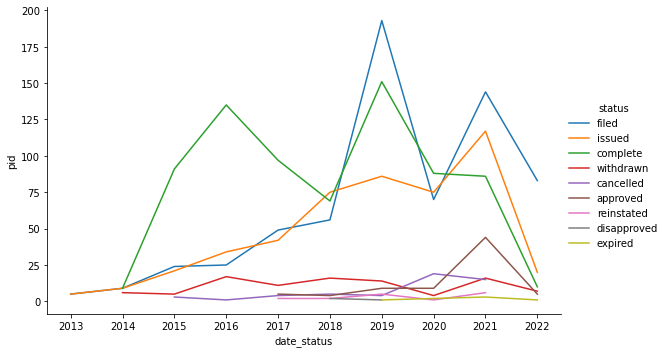

In [116]:
import seaborn

date_col = 'date_status'

sfb_plot = sfb[[date_col, 'units_prop', 'status', 'pid']]
sfb_plot[date_col] = sfb_plot[date_col].dt.to_period("Y").astype(str)

sfb_plot = sfb_plot.groupby([
    date_col, 'status'
    ]).agg({'units_prop':'sum', 'pid':'count'}).reset_index(drop=False)

seaborn.relplot(
    data=sfb_plot, 
    x=date_col, y='pid', hue='status', 
    aspect=1.61, kind="line"
    )


<AxesSubplot:>

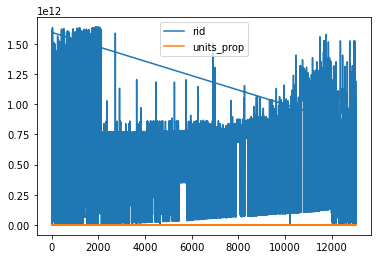

In [59]:
approved_status = [
    'complete', 'issued',
    'filing', 'filed', 'disapproved', 'reinstated', 'appeal',
    'approved'
]

sfb.loc[sfb['status'].isin(approved_status)].plot()

## Exploratory Data Analysis

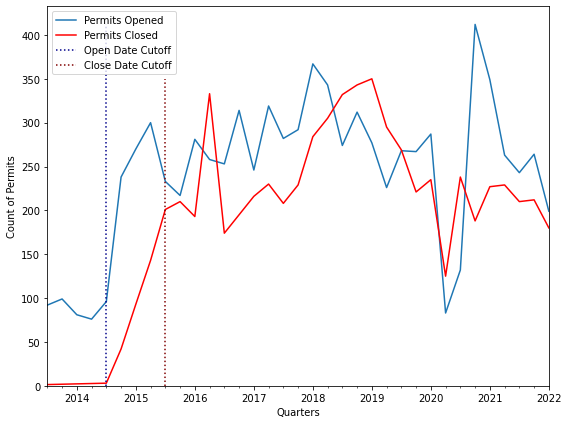

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

date_open = '2014Q3'
date_close = '2015Q3'

fig  = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

def date_group(date_col, period = 'Q', group_df = sfp_all):
    return group_df.sort_values(date_col).groupby(group_df[date_col].dt.to_period(period))['id'].count()

date_col = 'date_open'
open_df = date_group(date_col)
open_df.plot(ax=ax, kind="line", label='Permits Opened')
#date_group(date_col, period="Y").plot(ax=ax, color='black', kind="bar")

date_col = 'date_close'
close_df = date_group(date_col)
close_df.plot(ax=ax, color='red', kind="line", label='Permits Closed')

ax.set_xlim(['2013Q3',None])
ax.set_ylim([0,None])

col = 'darkblue'
ax.vlines(
    x=date_open, ymin=0, ymax=max(open_df), colors=col, ls=':',
    label = 'Open Date Cutoff')
#ax.hlines(y=max(open_df), xmin=date_open, xmax=max(open_df.index), colors=col, ls=':')

col = 'maroon'
ax.vlines(
    x=date_close, ymin=0, ymax=max(close_df), colors=col, ls=':',
    label = 'Close Date Cutoff'
    )
#ax.hlines(y=max(close_df), xmin=date_close, xmax=max(close_df.index), colors=col, ls=':')

ax.set_xlabel('Quarters')
ax.set_ylabel('Count of Permits')
ax.legend(loc='best')

plt.show()

Period('2022Q1', 'Q-DEC')

In [ ]:
#sfp[sfp['date_open']>='2015-01-01'].count()
#sfp[sfp['date_open']<'2015-01-01'].count()

sfp['date_openclose'] = sfp['date_open'].astype(str) + sfp['date_close'].astype(str)

sfp['length'] = (sfp['date_close'] - sfp['date_open']).dt.days
#(sfp['length']/365).hist()

long_plot = sfp.dropna(subset=['date_open','date_close'])

#fig  = plt.figure(figsize = (8,6))
#ax = fig.add_subplot(111)

period = 'Q'
#ax.barh(
#    long_plot.date_open.dt.to_period(period), 
#    long_plot.date_close.dt.to_period(period), 
#    left=long_plot.date_open.dt.to_period(period))


In [35]:
a = sfp['date_app_acc'].dropna().count()
t = len(sfp)

a/t

unit_max = 100000
sjp_join = sfp[sfp['#units_prop']<unit_max].copy()

sfp_nhood = sjp_join.groupby('nhood')['id'].count().to_dict()
sfnhood['permit_count'] = sfnhood['nhood'].map(sfp_nhood).fillna(value=0).astype(int)


sfp_unit = sjp_join.groupby('nhood')['#units_prop'].sum().to_dict()
sfnhood['unit_prop_count'] = sfnhood['nhood'].map(sfp_unit).fillna(value=0)

sjp_join['unit_per_permit'] = sjp_join['#units_prop']/1
sfp_upp = sjp_join.groupby('nhood')['unit_per_permit'].median().to_dict()
sfnhood['unit_per_permit'] = sfnhood['nhood'].map(sfp_upp).fillna(value=0)

In [36]:
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase

class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})

def set_label(
    bins,
    zero = True,
    binder = '-'
    ):
    binder = ' {} '.format(binder)

    if zero == True:
        bins = [0] + bins

    bins = list(zip(bins[:-1],bins[1:]))

    def to_string(pair):
        paired = str(pair[0]) + binder + str(pair[1])
        return paired

    bins = [to_string(bin) for bin in bins]
    bins = [
        '0' if bin == '0' + binder + '0'
        else bin 
        for bin in bins
        ]
    return bins

def set_legend(leg, new_texts, location=2):
    
    leg._loc = location

    for lbl,new_text in zip(leg.get_texts(), new_texts):
        label_text = lbl.get_text()
        #lower = label_text.split()[0]
        #upper = label_text.split()[2]
        #new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
        lbl.set_text(new_text)

C:\Users\nelms\AppData\Local\Temp\ipykernel_7428\3268762778.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)
C:\Users\nelms\AppData\Local\Temp\ipykernel_7428\3268762778.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)


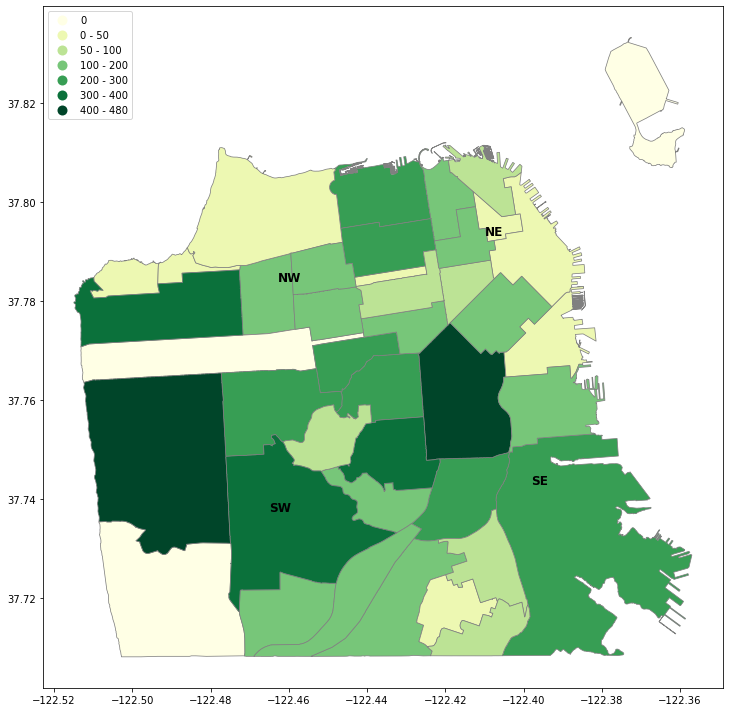

In [37]:
plot_col = 'permit_count'

map_bin = dict(bins=[0,50,100,200,300,400, sfnhood[plot_col].max()])

ax = sfnhood.plot(
    column=plot_col, 
    cmap='YlGn', 
    figsize=(40, 10), 
    scheme='User_Defined',
    classification_kwds=map_bin, k=len(map_bin)-1, 
    legend=True, linewidth=0.75, edgecolor='grey')

sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)
for x, y, label in sfquads:
    ax.annotate(
        label, xy=(x, y), xytext=(3, 3), 
        textcoords="offset points",
        fontsize='large',
        fontweight='bold'
        )

leg = ax.get_legend()
set_legend(leg, set_label(map_bin['bins']))

In [ ]:
sfnhood['permit_count'].hist()

In [ ]:
from matplotlib.text import Text
from matplotlib.legend import Legend

handles = list(string.ascii_uppercase)[:N] 
labels = [f"Model Name {c}" for c in handles]

fig, ax = plt.subplots()
ax.scatter(x, y, s=100, c=colors, alpha=0.5)
for i, xy in enumerate(zip(x, y)):
    ax.annotate(handles[i], xy=xy)

ax.legend(handles=handles, labels=labels)

In [ ]:
sfp.sort_values('#units_prop', ascending=False).head(30)

In [ ]:
path = r'static_data\sf_permit_acronyms.xlsx'
sfp_acr = pd.read_excel(path)
sfp_acr = {
    acr:name for acr,name in sfp_acr.set_index('Acronym')['Name'].to_dict().items()
    if type(acr) == str
}